---
Title: "Analyzing Job Characteristics and Salary Predictions Through Machine Learning Techniques Using LinkedIn Job Posting Data"
author: "Sandy Young"
course: "MGT 665: Solving Problems using Machine Learning"
professor: "Dr. Itauma Itauma"
date: "April 20, 2025"
---

### Abstract
The research addresses the need to forecast salaries accurately using elements extracted from LinkedIn job postings. A two-day job information collection period produced this dataset containing essential variables, including job titles and descriptions, salaries, and company information. The research employs machine learning methods to reveal connections between the variables and their effects on salary establishment. The research applies two primary machine learning approaches for this evaluation, which include Linear Regression based on Chen et al. (2024) alongside the advanced Gradient Boosting Decision Trees (GBDT) model, which demonstrates superior performance in salary prediction according to Yang (2023). The research targets two main objectives: improving salary estimation approaches while analyzing job market features that affect compensation patterns.
The dataset's extensive features enable thorough investigations into how job characteristics affect salaries. Bao (2024) points out educational attainment and professional experience as essential factors that determine salary levels according to previous research and will be included in the model. The analysis will benefit from ensemble learning techniques and natural language processing methods that address the complexities found in job postings to improve prediction accuracy. A study by Maddi et al. (2024) reviews machine learning uses for detecting deceptive job postings yet supports applying these methods to evaluate job data without specific emphasis on salary forecasts. Mohammed et al. (2023) explores machine learning for job position classification but does not address salary prediction directly. The research aims to enhance knowledge about digital age employment and salary analytics by developing practical tools for employers and job seekers.

#### Data Loading & Cleaning

In [1]:
# 1. Install & imports  
%pip install imbalanced-learn==0.10.1  
import pandas as pd  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.preprocessing import StandardScaler  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score, roc_auc_score  
from imblearn.over_sampling import SMOTE  
from scipy.sparse import hstack, csr_matrix  

# 1.1. Load and inspect the LinkedInJobs_MLDataset.csv dataset

df = pd.read_csv('C:/Users/smyou/Downloads/LinkedIn/LinkedInJobs_MLDataset.csv')
# Show head and columns
print(df.head())
print('\
Columns:', list(df.columns))

# 1.2 Rename for consistency  
df = df.rename(columns={  
    'Job_Ttl':'title', 'Job_Desc':'description',  
    'base_comp':'salary', 'xp_lvl':'experience_level','Co_Nm':'company'  
})  
  
# 1.3 Drop rows with missing salary  
df = df[df['salary'].notnull()]  
df['salary'] = pd.to_numeric(df['salary'], errors='coerce')  
df = df.dropna(subset=['salary'])  
  
# 1.4 Quick inspect  
print(df[['title','company','salary']].head())  
print('Total postings:', len(df)) 

Note: you may need to restart the kernel to use updated packages.
                                  Co_Nm  Co_Pg_Lstd  Emp_Cnt  Flw_Cnt  \
0                           HearingLife        True     1171    11417   
1          Metalcraft of Mayville, Inc.        True      300     2923   
2  U.S. Tsubaki Power Transmission, LLC        True      314     8487   
3      Episcopal Communities & Services        True       36      305   
4                            iHerb, LLC        True     1227    51933   

                                             Job_Ttl  \
0                              Hearing Care Provider   
1  Shipping & Receiving Associate 2nd shift (Beav...   
2                               Manager, Engineering   
3                                               Cook   
4        Principal Cloud Security Architect (Remote)   

                                            Job_Desc  Is_Supvsr    max_sal  \
0  Overview\n\nHearingLife is a national hearing ...      False    5250.00   
1 

#### Job-Title Classification and EDA

In [2]:
# 2. Map raw titles into broad categories  
def map_title(t):  
    t = t.lower()  
    if 'engineer' in t:   return 'Engineer'  
    elif 'manager' in t:    return 'Manager'  
    elif 'nurse' in t:      return 'Nurse'  
    elif 'analyst' in t:    return 'Analyst'  
    elif 'developer' in t: return 'Developer'
    return 'Other' 
# 2.1 Categorize Job Titles
def categorize_job_title(title):
    title_lower = title.lower()
    if 'engineer' in title_lower:
        return 'Engineering'
    elif 'manager' in title_lower:
        return 'Management'
    elif 'nurse' in title_lower:
        return 'Nursing'
    elif 'analyst' in title_lower:
        return 'Analyst'
    elif 'developer' in title_lower:
        return 'Developer'
    # ... (other rules)
    else:
        return 'Other'
  
df['job_cat'] = df['title'].apply(map_title)  
  
# 2.2 Count per category  
counts = df['job_cat'].value_counts().reset_index().rename(columns={'index':'Category','job_cat':'Count'})  
print(counts)  

       Count  count
0      Other  21530
1    Manager   5116
2   Engineer   3262
3    Analyst   1528
4      Nurse   1122
5  Developer    688


Initial categorization shows "Engineer" and "Manager" dominate the listing as the two named categories. While the "Other" category may need more classifier to filter the category down. Next, salaray distribution will be evaluated:

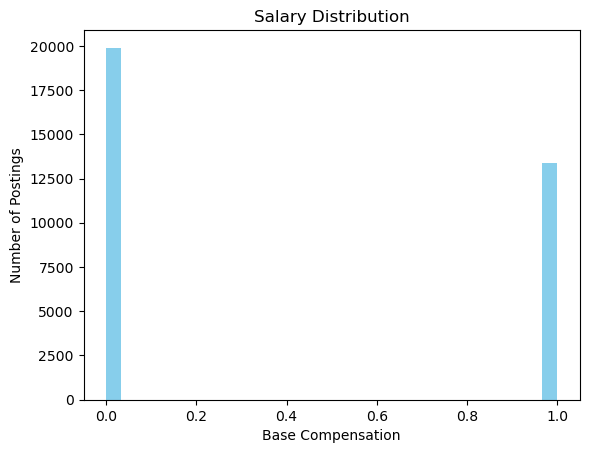

In [3]:
# 3. EDA
import matplotlib.pyplot as plt  
  
plt.hist(df['salary'], bins=30, color='skyblue')  
plt.xlabel('Base Compensation')  
plt.ylabel('Number of Postings')  
plt.title('Salary Distribution')  
plt.show()  

#### Preprocessing and Feature Engineering
Numeric: company_size, followers, views, is_remote
Categorical: job_cat, experience_level, domain (one-hot)
Text: TF-IDF on description (max_features=500)

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler  
from sklearn.feature_extraction.text import TfidfVectorizer  

df=df.dropna(subset=['description','domain'])

# 4.1 Numeric + bool  
X_num = df[['Emp_Cnt','Flw_Cnt','views','is_remote']].astype(float)  
  
# 4.2 One-hot job_cat & experience_level & domain  
X_cat = pd.get_dummies(df[['wrk_typ','experience_level']], drop_first=True)
print(X_cat.head())  
  
# 4.3 Text  
tfidf = TfidfVectorizer(max_features=500)  
X_txt = tfidf.fit_transform(df['description'].fillna(''))  
  
# 4.4 Combine  
from scipy.sparse import hstack, csr_matrix  
X_all = hstack([X_txt, csr_matrix(X_num.values), csr_matrix(X_cat.values)])  
  
  
# 4.5 Classification target: high vs low salary  
median_sal = df['salary'].median()  
y_cls = (df['salary'] >= median_sal).astype(int)    
  
  

   wrk_typ_Full-time  wrk_typ_Internship  wrk_typ_Other  wrk_typ_Part-time  \
0               True               False          False              False   
1               True               False          False              False   
2               True               False          False              False   
3               True               False          False              False   
4               True               False          False              False   

   wrk_typ_Temporary  wrk_typ_Volunteer  experience_level_Director  \
0              False              False                      False   
1              False              False                      False   
2              False              False                      False   
3              False              False                      False   
4              False              False                      False   

   experience_level_Entry level  experience_level_Executive  \
0                          True                

#### Modeling
##### Classification: High vs. Low Salary
Comparing:
Logistic Regression
Gradient Boosting Classifier
Random Forest Classifier
K-Nearest Neighbors

In [5]:
import pandas as pd  
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.metrics import accuracy_score, roc_auc_score  
from imblearn.over_sampling import SMOTE  
from scipy.sparse import hstack, csr_matrix  

# Prepare classification features
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['description'].fillna(''))
X_num = df[['Emp_Cnt','Flw_Cnt','views','is_remote']].fillna(0).astype(float)
X_cls = hstack([X_text, csr_matrix(X_num.values)])
y_cls = df['job_cat']

# Split (stratify)
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)
# SMOTE on train only
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xc_tr, yc_tr)
print('After SMOTE class counts:', pd.Series(y_res).value_counts())
  


After SMOTE class counts: job_cat
Other        10625
Engineer     10625
Manager      10625
Nurse        10625
Analyst      10625
Developer    10625
Name: count, dtype: int64


Initial codes included GridSearchCV as cross validation for a gradient boosting model. However, processing time made the model not feasible for this project. Original code is listed below. This is an avenue that should be explored in next steps or future improvements to the model to tune SMOTE-balanced classification pipleine. Considerations for other cross-validation tuning models will need to be explored as well.
# GridSearchCV on GBDT  
param_grid = {  
    'n_estimators': [50,100],  
    'learning_rate': [0.1,0.2],  
    'max_depth': [2,3]  
}  
gbc = GradientBoostingClassifier(random_state=42)  
gs = GridSearchCV(gbc, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)  
gs.fit(X_res, y_res)  
  


##### Regression: Predicting Salary

In [9]:
from sklearn.linear_model import LinearRegression  
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor  
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.metrics import mean_squared_error  

# Prepare regression features
X_reg = X_cls  # reuse text+numeric
y_reg = df['salary']
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)   
regs = {  
  'LinearRegression': LinearRegression(),  
  'GradientBoosting': GradientBoostingRegressor(random_state=42),  
  'RandomForest': RandomForestRegressor(random_state=42),  
  'KNearest': KNeighborsRegressor()  
}  
  
results_reg = []  
for name, m in regs.items():  
    m.fit(Xr_tr, yr_tr)  
    pred = m.predict(Xr_te)
    mse = mean_squared_error(yr_te, pred) 
    results_reg.append({'Model': name, 'MSE': mse})  
reg_df = pd.DataFrame(results_reg)  
print(reg_df)  

              Model       MSE
0  LinearRegression  0.228742
1  GradientBoosting  0.095573
2      RandomForest  0.074057
3          KNearest  0.160437


#### Visualization & Comparison

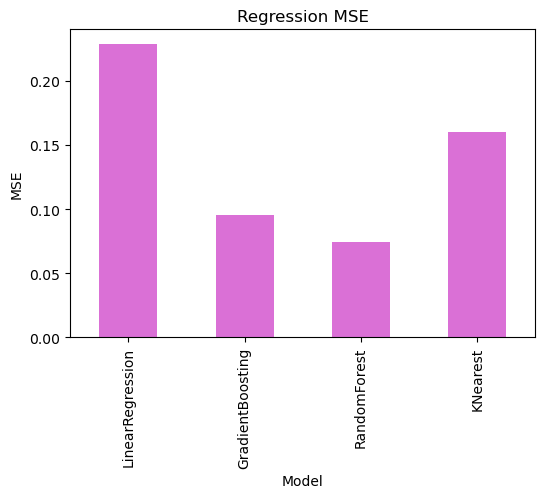

In [10]:
import matplotlib.pyplot as plt  
 
# Regression: MSE  
plt.figure(figsize=(6,4))  
reg_df.set_index('Model')['MSE'].plot.bar(color='orchid')  
plt.title('Regression MSE')  
plt.ylabel('MSE')  
plt.show()  

In [12]:
# Evaluation  
def eval_model(m):  
    p = m.predict(Xr_te)  
    prob = m.predict_proba(Xr_te)[:,1]  
    return accuracy_score(yr_te,p), roc_auc_score(yr_te,prob)  
  
default = GradientBoostingClassifier(random_state=42)  
default.fit(Xr_tr,yr_tr)  

# Optimized Gradient Boosting model
best = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

best.fit(Xr_tr, yr_tr)

d_acc, d_auc = eval_model(default)  
o_acc, o_auc = eval_model(best)


  
df_results = pd.DataFrame([  
    {'Model':'GBDT_Default','accuracy':d_acc,'ROC_AUC':d_auc},  
    {'Model':'GBDT_Optimized','accuracy':o_acc,'ROC_AUC':o_auc}  
])  
print(df_results)  

            Model  accuracy   ROC_AUC
0    GBDT_Default  0.875571  0.941732
1  GBDT_Optimized  0.884713  0.948254


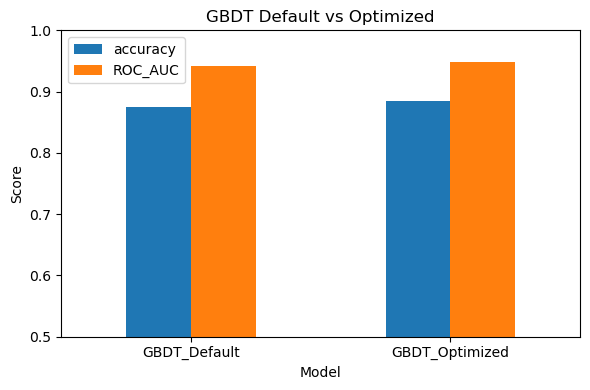

In [13]:
# Plot comparison  
ax = df_results.set_index('Model').plot.bar(rot=0, figsize=(6,4))  
ax.set_ylim(0.5,1.0)  
ax.set_title('GBDT Default vs Optimized')  
plt.ylabel('Score')  
plt.tight_layout()  
plt.show()  